In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble, IBMQ
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA, ADAM
from qiskit.tools.monitor import job_monitor
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult

ACC_COUNT = 10
DIR_val_train = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/amp_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/amp_enc_data_set_test_classes.csv"

#IBMQ.save_account("07916ec631273d08971f67f1267677801b440be43215767571a165abe0ac621415a17cc5a357e2e2fffa511a6fd3748eb0c46d35ca79d8752b97788fd71f390a", overwrite=True)
#IBMQ.load_account()

# Circuito

In [2]:
n_qubits = 4

encoding = RawFeatureVector(16)

#2 Fica num platue de cost = 2
ansatz = EfficientSU2(n_qubits, entanglement='full', reps=3, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")

qc = encoding.compose(ansatz)
qc.measure_all()

In [3]:
def get_encode(file):
    """
     Funcao responsavel pelo encoding (amplitude)
        Input :: 
        ### file : File dir
        Output :: 
        #### data_enc : Valores para o encode (numpy array)
    """
    return np.genfromtxt(file, delimiter=";")

In [4]:
train_data = get_encode(DIR_val_train)
train_labels = get_encode(DIR_cls_train)

test_data = get_encode(DIR_val_test)
test_labels = get_encode(DIR_cls_test)

In [5]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [6]:
def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [22]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):

    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result() #Noise
    

    predictions = [classification(results.get_counts(c)) for c in circuits]
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [23]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        exp_val += ((-1)**(count_ones(state)%2))*prob

    if label:
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    return (y-y_hat)*(y-y_hat)

In [24]:
opt_var1, opt_value1 , parameters, costs, evaluations = train(qc,
                                                              encoding,
                                                              ansatz,
                                                              train_data,
                                                              train_labels,
                                                              self_encoding=True, 
                                                              initial_point=opt_var1)

Cost 1.5
Cost 1.05
Cost 0.75
Cost 0.9
Cost 0.85
Cost 1.5
Cost 0.55
Cost 0.65
Cost 0.65
Cost 1.2
Cost 0.4
Cost 0.65
Cost 1.0
Cost 1.3
Cost 2.0
Cost 1.7
Cost 1.95
Cost 1.85
Cost 0.75
Cost 1.2
Cost 1.9
Cost 0.7
Cost 0.55
Cost 2.0
Cost 0.5
Cost 1.9
Cost 1.0
Cost 1.55
Cost 1.9
Cost 1.45
Cost 1.15
Cost 2.1
Cost 2.0
Cost 1.6
Cost 0.85
Cost 2.0
Cost 1.6
Cost 0.95
Cost 1.7
Cost 1.95
Cost 1.45
Cost 0.7
Cost 0.9
Cost 0.55
Cost 0.9
Cost 1.5
Cost 1.2
Cost 1.55
Cost 1.1
Cost 1.55
Cost 0.6
Cost 1.1
Cost 1.95
Cost 2.0
Cost 1.85
Cost 1.85
Cost 1.75
Cost 1.95
Cost 1.85
Cost 1.75
Cost 1.9
Cost 1.75
Cost 1.55
Cost 1.85
Cost 1.45
Cost 1.0
Cost 1.9
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 1.35
Cost 0.75
Cost 2.0
Cost 1.95
Cost 1.05
Cost 1.0
Cost 0.9
Cost 0.55
Cost 0.65
Cost 1.2
Cost 0.8
Cost 1.65
Cost 0.65
Cost 1.85
Cost 2.0
Cost 2.0
Cost 1.85
Cost 0.55
Cost 2.0
Cost 2.0
Cost 1.8
Cost 2.0
Cost 1.9
Cost 1.75
Cost 3.1
Cost 1.15
Cost 1.95
Cost 2.0
Cost 1.2
Cost 1.25
Cost 0.95
Cost 1.25
Cost 1.7
Cost 1

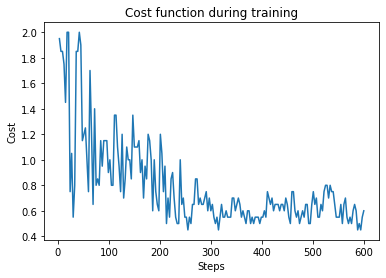

In [25]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("Cost function during training")
plt.show()

In [26]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()
    
    prediction = [classification(results.get_counts(c)) for c in circuits]
    
    print(labels)
    print(prediction)
    accuracy = 0
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [27]:
acc = []
for _ in range(ACC_COUNT):
    accuracy, prediction = func_accuracy(test_data, test_labels, opt_var1, self_encoding=True)
    print("Test set accuracy - {}".format(accuracy))
    acc += [accuracy]
print("Test set accuracy (mean) - {}".format(sum(acc)/ACC_COUNT))    

[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1]
Test set accuracy - 0.8333333333333334
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1]
Test set accuracy - 0.875
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1]
Test set accuracy - 0.875
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1]
Test set accuracy - 0.875
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1,

## Cross Entropy Loss

### Parity method

In [28]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [29]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    return probs

def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    return np.sum(y*np.log(y_hat))

In [30]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]
    
    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [31]:
opt_var, opt_value , parameters, costs, evaluations = train(qc,
                                                            encoding,
                                                            ansatz,
                                                            train_data,
                                                            train_labels_oh,
                                                            self_encoding=True,
                                                            initial_point=opt_var)

Cost: 0.5230487696537638
Cost: 0.5289197775064179
Cost: 0.5225105770462861
Cost: 0.5174123935958106
Cost: 0.5286611225189034
Cost: 0.5236151949457263
Cost: 0.55767613683597
Cost: 0.6077187735648564
Cost: 0.5283471322858291
Cost: 0.5294891781529747
Cost: 0.5465513041217933
Cost: 0.503278630635992
Cost: 0.5387567832770529
Cost: 0.5413209583516936
Cost: 0.5493579292732067
Cost: 0.5595893139450435
Cost: 0.5469250829530891
Cost: 0.5517939813244493
Cost: 0.5323257028267208
Cost: 0.5440510479868106
Cost: 0.559300371400024
Cost: 0.5644778458988421
Cost: 0.5308449905315838
Cost: 0.5287999488937052
Cost: 0.5230165936511517
Cost: 0.5296544242341452
Cost: 0.5311476348502809
Cost: 0.5463683298264783
Cost: 0.5439190118942421
Cost: 0.5456445944207884
Cost: 0.5393798215609101
Cost: 0.5184126657530965
Cost: 0.5507045669522622
Cost: 0.5461896705272815
Cost: 0.5290435068220634
Cost: 0.5368370045587365
Cost: 0.5613065242043305
Cost: 0.5427647961927298
Cost: 0.48179659817436393
Cost: 0.5307432887903032
Cos

Cost: 0.7070194783976216
Cost: 0.6701595798081208
Cost: 0.729473802714109
Cost: 0.6027657934569539
Cost: 0.6010468726516398
Cost: 0.6360919541048202
Cost: 0.5799281670464154
Cost: 0.5660653190552395
Cost: 0.6341710287230564
Cost: 0.5524528364312024
Cost: 0.6192063610099101
Cost: 0.6143270029518115
Cost: 0.6776896974755428
Cost: 0.6204190418832436
Cost: 0.580487009552801
Cost: 0.619400525043271
Cost: 0.58677774475466
Cost: 0.5683828914000911
Cost: 0.5928437183665934
Cost: 0.5699938512024723
Cost: 0.6046807441034717
Cost: 0.5884787456064602
Cost: 0.5687142246140473
Cost: 0.6050984506064043
Cost: 0.6350305061698351
Cost: 0.6011960442246909
Cost: 0.6105340819566054
Cost: 0.651222622894701
Cost: 0.629482337461164
Cost: 0.6735229004972286
Cost: 0.5966646425122379
Cost: 0.6124193952927539
Cost: 0.6145487685795202
Cost: 0.6613815732903543
Cost: 0.6338264560559133
Cost: 0.650333364219462
Cost: 0.6959058088829799
Cost: 0.6533231102109027
Cost: 0.6839949373250013
Cost: 0.635712475774373
Cost: 0.6

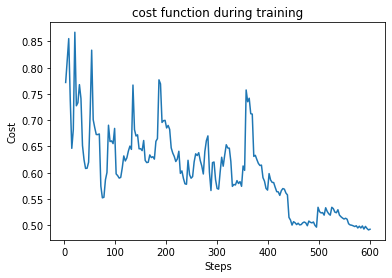

In [32]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [33]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [34]:
acc = []
for _ in range(ACC_COUNT):
    accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
    print("Test set accuracy - {}".format(accuracy))
    acc += [accuracy]
print("Test set accuracy (mean) - {}".format(sum(acc)/ACC_COUNT))

[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1]
Test set accuracy - 0.8333333333333334
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1]
Test set accuracy - 0.8333333333333334
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1]
Test set accuracy - 0.7916666666666666
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1]
Test set accuracy - 0.7916666666666666
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. 

In [35]:
print(len(train_data))

80
